# Bridge Monitoring – PySpark Streaming Demo

This notebook validates my end‑to‑end **bridge monitoring** pipeline built in pure PySpark Structured Streaming.

The project implements the **Bronze → Silver → Gold** medallion pattern:

- **Bronze** – raw IoT events from three sensor types: `temperature`, `vibration`, `tilt` written as JSON → Parquet.  
- **Silver** – cleaned & enriched data joined with static `bridges.csv` metadata and data‑quality rules.  
- **Gold** – 1‑minute windowed metrics per bridge: **average temperature**, **max vibration**, **max tilt angle**.

In this notebook I:

1. Start / reuse a Spark session.  
2. Inspect the **Gold** table to verify the windowed metrics.  
3. Inspect **Silver/rejected** to see data‑quality results.  
4. Inspect **Bronze** to confirm raw events are ingested per minute.  
5. Run one simple analytics query on top of the Gold table.  
6. Show the DAG / architecture diagram used in the written report.

## 1. Spark session & environment

In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("BridgeMonitoringDemo")
    .getOrCreate()
)

print("Spark version:", spark.version)
print("Application name:", spark.sparkContext.appName)

Spark version: 4.0.1
Application name: BridgeMonitoringDemo


In [2]:
BRONZE_TEMP_PATH   = r"C:\Users\HS Computers\bridge-monitoring-pyspark/bronze/bridge_temperature"
SILVER_REJECTED    = r"C:\Users\HS Computers\bridge-monitoring-pyspark/silver/rejected"
GOLD_METRICS_PATH  = r"C:\Users\HS Computers\bridge-monitoring-pyspark/gold/bridge_metrics"

print("Bronze temperature path :", BRONZE_TEMP_PATH)
print("Silver rejected path    :", SILVER_REJECTED)
print("Gold metrics path       :", GOLD_METRICS_PATH)

Bronze temperature path : C:\Users\HS Computers\bridge-monitoring-pyspark/bronze/bridge_temperature
Silver rejected path    : C:\Users\HS Computers\bridge-monitoring-pyspark/silver/rejected
Gold metrics path       : C:\Users\HS Computers\bridge-monitoring-pyspark/gold/bridge_metrics


## 2. Inspect Gold layer – `gold/bridge_metrics`

In [3]:
from pyspark.sql.functions import col

gold_df = spark.read.parquet(GOLD_METRICS_PATH)

print("Number of rows in gold_df:", gold_df.count())
gold_df.printSchema()
gold_df.show(20, truncate=False)

Number of rows in gold_df: 106
root
 |-- bridge_id: integer (nullable = true)
 |-- window_start: timestamp (nullable = true)
 |-- window_end: timestamp (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- max_vibration: double (nullable = true)
 |-- max_tilt_angle: double (nullable = true)

+---------+-------------------+-------------------+------------------+-------------+--------------+
|bridge_id|window_start       |window_end         |avg_temperature   |max_vibration|max_tilt_angle|
+---------+-------------------+-------------------+------------------+-------------+--------------+
|1        |2025-11-08 11:18:00|2025-11-08 11:19:00|25.844166666666666|9.079        |21.035        |
|5        |2025-11-08 11:18:00|2025-11-08 11:19:00|21.496250000000003|9.915        |25.252        |
|1        |2025-11-08 10:22:00|2025-11-08 10:23:00|27.106166666666663|8.77         |27.679        |
|3        |2025-11-08 10:25:00|2025-11-08 10:26:00|24.08223076923077 |9.741        |29.367 

## 3. Data‑quality results – `silver/rejected`

In [4]:
from pyspark.sql.functions import count

rejected_df = spark.read.parquet(SILVER_REJECTED)

total_rejected = rejected_df.count()
print("Total rows in rejected_df:", total_rejected)
rejected_df.printSchema()

if total_rejected == 0:
    print("In this run there are 0 rejected rows all events passed Silver‑layer rules.")
else:
    (
        rejected_df
        .groupBy("sensor_type")
        .agg(count("*").alias("rejected_count"))
        .orderBy("sensor_type")
        .show(truncate=False)
    )

Total rows in rejected_df: 0
root
 |-- event_time: string (nullable = true)
 |-- bridge_id: integer (nullable = true)
 |-- sensor_type: string (nullable = true)
 |-- value: double (nullable = true)
 |-- ingest_time: string (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- ingest_time_ts: timestamp (nullable = true)
 |-- partition_date: date (nullable = true)

In this run there are 0 rejected rows all events passed Silver‑layer rules.


## 4. Bronze layer – events per minute

In [5]:
from pyspark.sql.functions import to_timestamp, window

bronze_temp = spark.read.parquet(BRONZE_TEMP_PATH)

print("Rows in bronze temperature:", bronze_temp.count())
bronze_temp.printSchema()

events_per_min = (
    bronze_temp
    .withColumn("event_time_ts", to_timestamp("event_time_ts"))
    .groupBy(window(col("event_time_ts"), "1 minute"))
    .count()
    .orderBy("window")
)

events_per_min.show(truncate=False)

Rows in bronze temperature: 1592
root
 |-- event_time: string (nullable = true)
 |-- bridge_id: integer (nullable = true)
 |-- sensor_type: string (nullable = true)
 |-- value: double (nullable = true)
 |-- ingest_time: string (nullable = true)
 |-- date: date (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- ingest_time_ts: timestamp (nullable = true)
 |-- partition_date: date (nullable = true)

+------------------------------------------+-----+
|window                                    |count|
+------------------------------------------+-----+
|{2025-11-08 09:49:00, 2025-11-08 09:50:00}|71   |
|{2025-11-08 09:50:00, 2025-11-08 09:51:00}|126  |
|{2025-11-08 10:13:00, 2025-11-08 10:14:00}|86   |
|{2025-11-08 10:14:00, 2025-11-08 10:15:00}|52   |
|{2025-11-08 10:22:00, 2025-11-08 10:23:00}|24   |
|{2025-11-08 10:23:00, 2025-11-08 10:24:00}|96   |
|{2025-11-08 10:24:00, 2025-11-08 10:25:00}|29   |
|{2025-11-08 10:25:00, 2025-11-08 10:26:00}|116  |
|{2025-11-08 10:26

## 5. Example analytics – top bridges by max vibration

In [6]:
from pyspark.sql.functions import max as spark_max

top_vibration = (
    gold_df
    .groupBy("bridge_id")
    .agg(spark_max("max_vibration").alias("peak_vibration"))
    .orderBy(col("peak_vibration").desc())
)

top_vibration.show(10, truncate=False)


+---------+--------------+
|bridge_id|peak_vibration|
+---------+--------------+
|3        |9.994         |
|4        |9.98          |
|1        |9.975         |
|5        |9.952         |
|2        |9.908         |
+---------+--------------+



## 6. Pipeline DAG / architecture diagram

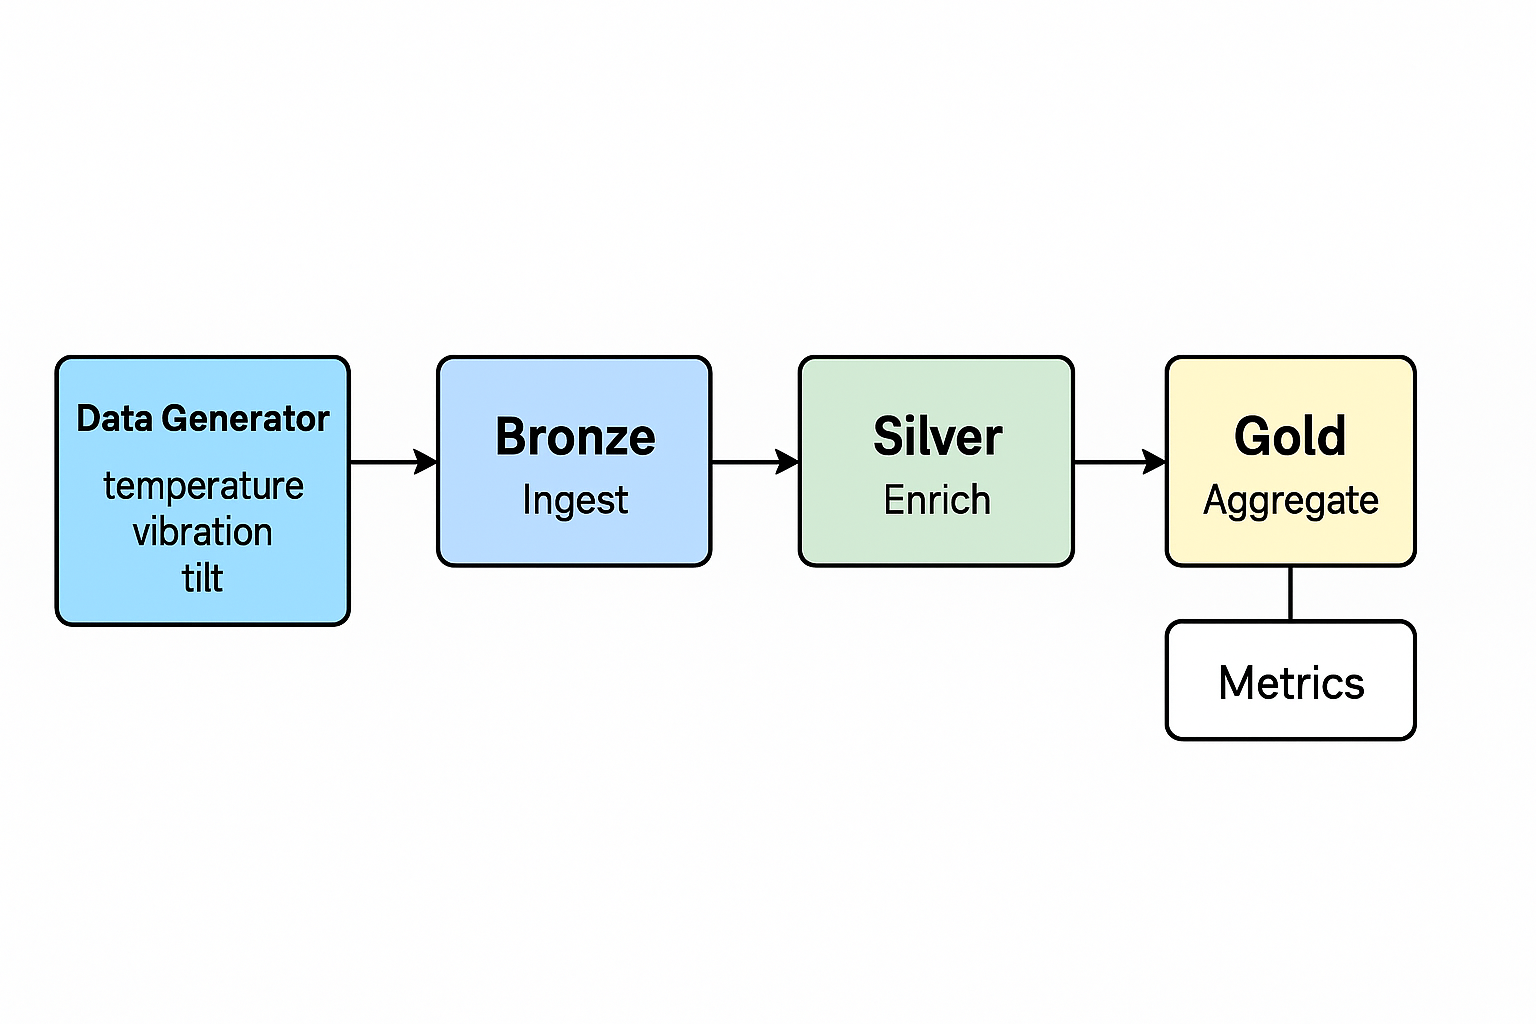

In [7]:
from IPython.display import Image, display
from pathlib import Path

dag_path = Path(r"C:\Users\HS Computers\bridge-monitoring-pyspark\notebooks\dag.png")

if dag_path.exists():
    display(Image(filename=str(dag_path)))
else:
    print("DAG image not found:", dag_path)


## 7. Summary

This notebook shows that:

1. The **Gold** table `gold/bridge_metrics` contains 1‑minute windowed metrics per bridge.  
2. The **Silver** layer routes any rows that fail expectations into `silver/rejected` (0 rows in the latest run).  
3. The **Bronze** layer is ingesting raw events continuously and we can see per‑minute counts.  
4. On top of the Gold layer we can already run simple analytics such as *top bridges by peak vibration*.  

Together with the scripts in `pipelines/` and the generator in `data_generator/`, this notebook completes the
validation & ad‑hoc queries part of the assignment.

Join Success Rate (Stream → Static Metadata)

This cell validates how many streaming sensor records in the Silver layer successfully joined with the static bridge metadata (bridges.csv).
It measures data quality by showing the percentage of records that matched a known bridge ID — an essential metric for verifying the enrichment process.

In [8]:
from pyspark.sql.functions import col

SILVER_TEMP_PATH = r"C:\Users\HS Computers\bridge-monitoring-pyspark\silver\bridge_temperature"

silver_temp_df = spark.read.parquet(SILVER_TEMP_PATH)

total = silver_temp_df.count()
matched = silver_temp_df.filter(col("name").isNotNull()).count()

print(f"Total temperature records: {total}")
print(f"Records with matching bridge metadata: {matched}")
if total > 0:
    print(f"Join success rate (temperature stream → bridges.csv): {matched/total:.2%}")
else:
    print("No records found in silver/bridge_temperature.")


Total temperature records: 1592
Records with matching bridge metadata: 1592
Join success rate (temperature stream → bridges.csv): 100.00%


### 8. Watermark behaviour & late events (experiment)

The gold aggregation pipeline uses a **2-minute watermark** on `event_time_ts`.  
Conceptually, a watermark tells Spark:

> “If an event is **older than (max_seen_event_time – watermark)**, treat it as **too late** and drop it from aggregations.”

In this section we approximate that behaviour on the **Silver temperature** data using batch code:

* We read `silver/bridge_temperature` as a static DataFrame.
* We find the latest `event_time_ts` that arrived.
* We simulate two different watermark sizes:
  * **Large watermark (2 minutes)** → more late events are still accepted.
  * **Small watermark (10 seconds)** → many more late events are considered “too late”.
* We compare how many rows would be **accepted** under each watermark.

This serves as:
* A **unit-style check** that late events inside the watermark window are kept.
* A **small experiment** showing the effect of “watermark too small vs too large”.


In [9]:
from pyspark.sql.functions import col, max as spark_max, min as spark_min

silver_temp_df = spark.read.parquet(SILVER_TEMP_PATH)

print("Silver temperature row count:", silver_temp_df.count())
silver_temp_df.select(
    spark_min("event_time_ts").alias("min_event_time_ts"),
    spark_max("event_time_ts").alias("max_event_time_ts"),
).show(truncate=False)


Silver temperature row count: 1592
+--------------------------+--------------------------+
|min_event_time_ts         |max_event_time_ts         |
+--------------------------+--------------------------+
|2025-11-08 09:49:07.525822|2025-11-08 13:50:16.479799|
+--------------------------+--------------------------+



In [10]:
from pyspark.sql.functions import expr

# Latest event time we have seen
max_ts = silver_temp_df.select(spark_max("event_time_ts")).collect()[0][0]
print("Latest event_time_ts in silver_temperature:", max_ts)

# Simulated watermark sizes
large_wm = "INTERVAL 2 MINUTES"
small_wm = "INTERVAL 10 SECONDS"

# Cutoff times that mimic watermark behaviour:
# keep rows where event_time_ts >= max_ts - watermark
large_cutoff = silver_temp_df.select(
    expr(f"timestampadd(MINUTE, -2, TIMESTAMP '{max_ts}')").alias("cutoff_large")
).collect()[0][0]

small_cutoff = silver_temp_df.select(
    expr(f"timestampadd(SECOND, -10, TIMESTAMP '{max_ts}')").alias("cutoff_small")
).collect()[0][0]

print("Simulated 2-minute watermark cutoff: ", large_cutoff)
print("Simulated 10-second watermark cutoff:", small_cutoff)

accepted_large = silver_temp_df.filter(col("event_time_ts") >= large_cutoff).count()
accepted_small = silver_temp_df.filter(col("event_time_ts") >= small_cutoff).count()

print(f"Rows kept with 2-minute watermark   : {accepted_large}")
print(f"Rows kept with 10-second watermark : {accepted_small}")
print(f"Dropped when watermark is too small: {accepted_large - accepted_small}")


Latest event_time_ts in silver_temperature: 2025-11-08 13:50:16.479799
Simulated 2-minute watermark cutoff:  2025-11-08 13:48:16.479799
Simulated 10-second watermark cutoff: 2025-11-08 13:50:06.479799
Rows kept with 2-minute watermark   : 225
Rows kept with 10-second watermark : 10
Dropped when watermark is too small: 215
